https://www.kaggle.com/c/aerial-cactus-identification/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn, gc, time, os, math

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2.3.0


### load the data

In [2]:
train_df = pd.read_csv("train.csv")
train_dir = '/cp/kaggle/aerial-cactus-identification/train/train/'

print(train_df.shape)
train_df.head()

(17500, 2)


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


1    13136
0     4364
Name: has_cactus, dtype: int64


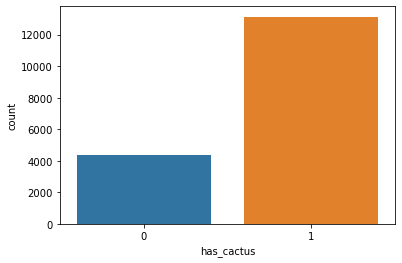

In [3]:
print(train_df["has_cactus"].value_counts())
seaborn.countplot(train_df["has_cactus"])

### visualise the data

In [4]:
train_df[train_df["has_cactus"] == '1']["id"][:5]

C:\Users\rahul\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Series([], Name: id, dtype: object)

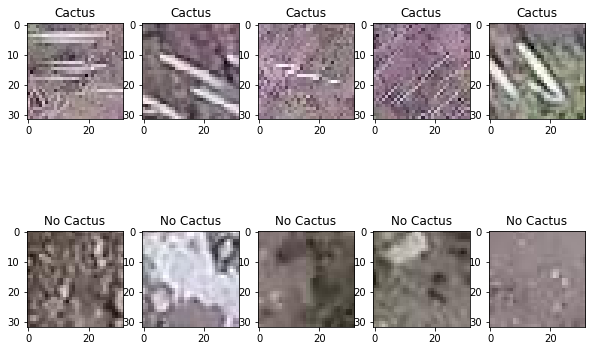

In [5]:
fig,ax = plt.subplots(2,5, figsize=(10,7))

for i, index in enumerate(train_df[train_df["has_cactus"] == 1]["id"][:5]):
    path = os.path.join(train_dir, index)
    img = load_img(path)
    ax[0,i].set_title("Cactus")
    ax[0,i].imshow(img)
    
for i, index in enumerate(train_df[train_df["has_cactus"] == 0]["id"][:5]):
    path = os.path.join(train_dir, index)
    img = load_img(path)
    ax[1,i].set_title("No Cactus")
    ax[1,i].imshow(img)

### split the data

In [6]:
# convert target variable into 'str' type to avoid below error
# TypeError: If class_mode="binary", y_col="has_cactus" column values must be strings.
train_df["has_cactus"] = train_df["has_cactus"].astype('str')

print("before split train shape", train_df.shape)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["has_cactus"], shuffle=True, random_state=seed)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("after split train/val shape", train_df.shape, val_df.shape)

before split train shape (17500, 2)
after split train/val shape (14000, 2) (3500, 2)


### prepare data for modeling

In [7]:
img_width, img_height = 32,32
target_size = (img_width, img_height)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                   directory=train_dir,
                                                   x_col='id',
                                                   y_col='has_cactus',
                                                   target_size=target_size,
                                                    class_mode='binary',
                                                   batch_size=batch_size,
                                                   seed = seed)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                   directory=train_dir,
                                                   x_col='id',
                                                   y_col='has_cactus',
                                                   target_size=target_size,
                                                    class_mode='binary',
                                                   batch_size=batch_size,
                                                   seed = seed)


Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.


### create CNN model from scratch

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool2D, Dropout
from tensorflow.keras.models import Sequential, Model

In [9]:
inputs = Input(shape=(*target_size, 3))

x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPool2D((2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Dropout(0.25)(x)

x = GlobalMaxPool2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [10]:
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC'])

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)         

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

earlyStopping = EarlyStopping(patience=5)

def decay(epoch):
    init_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = init_lr * math.pow(drop, math.floor((epoch) / epochs_drop))
    
    return lr


lrScheduler = LearningRateScheduler(schedule=decay)

In [13]:
epochs = 20

history = model.fit(train_generator, batch_size=64, epochs=epochs, validation_data=val_generator, 
                    steps_per_epoch=train_generator.n//batch_size, validation_steps=val_generator.n//batch_size,
                    callbacks=[earlyStopping, lrScheduler])

Epoch 1/20
437/437 [==============================] - 4s 9ms/step - loss: 0.2058 - auc: 0.9652 - val_loss: 0.1831 - val_auc: 0.9871
Epoch 2/20
437/437 [==============================] - 4s 8ms/step - loss: 0.1251 - auc: 0.9868 - val_loss: 0.1596 - val_auc: 0.9923
Epoch 3/20
437/437 [==============================] - 4s 8ms/step - loss: 0.0908 - auc: 0.9924 - val_loss: 0.0654 - val_auc: 0.9970
Epoch 4/20
437/437 [==============================] - 4s 8ms/step - loss: 0.0737 - auc: 0.9946 - val_loss: 0.0598 - val_auc: 0.9972
Epoch 5/20
437/437 [==============================] - 4s 8ms/step - loss: 0.0900 - auc: 0.9925 - val_loss: 0.0821 - val_auc: 0.9968
Epoch 6/20
437/437 [==============================] - 4s 8ms/step - loss: 0.0659 - auc: 0.9955 - val_loss: 0.0652 - val_auc: 0.9984
Epoch 7/20
437/437 [==============================] - 4s 8ms/step - loss: 0.0543 - auc: 0.9969 - val_loss: 0.0492 - val_auc: 0.9983
Epoch 8/20
437/437 [==============================] - 4s 8ms/step - loss: 0.

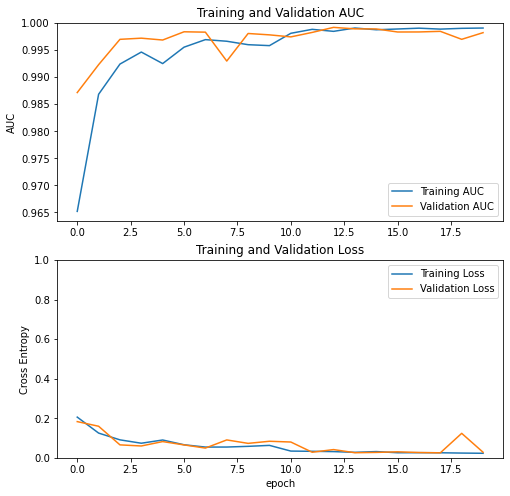

In [14]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training AUC')
plt.plot(val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
test_df = pd.read_csv("sample_submission.csv")
test_dir = '/cp/kaggle/aerial-cactus-identification/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                 target_size=target_size,
                                 class_mode='binary',
                                 batch_size=1,
                                 shuffle=False,
                                 seed=seed)



Found 4000 images belonging to 1 classes.


In [16]:
preds = model.predict(test_generator)
test_df["has_cactus"] = preds
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.992666
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.007337
3,002e175c3c1e060769475f52182583d0.jpg,0.003187
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.633145
